In [0]:

import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = int(np.sqrt(input_dim))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
class Autoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        # Set hyperparameters
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        # Build the graph
        self.build()

        # Initialize paramters
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        tf.reset_default_graph()        
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z = fc(f3, self.n_z, scope='enc_fc4', activation_fn=tf.nn.relu)

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Optimizer
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.recon_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss
        }
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [0]:
def trainer(model_class, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, log_step=5):
    # Create a model    
    model = model_class(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    # Training loop    
    for epoch in range(num_epoch):
        start_time = time.time()
        
        # Run an epoch
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and backward pass 
            # Report computed loss
            losses = model.run_single_step(batch[0])
        end_time = time.time()
        
        # Log the loss
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [0]:
model = trainer(Autoencoder)

[Epoch 0] recon_loss: 154.042  (15.037 sec/epoch)
[Epoch 5] recon_loss: 98.641  (15.058 sec/epoch)
[Epoch 10] recon_loss: 95.886  (15.001 sec/epoch)
[Epoch 15] recon_loss: 85.707  (15.217 sec/epoch)
[Epoch 20] recon_loss: 84.436  (15.029 sec/epoch)
[Epoch 25] recon_loss: 84.331  (14.977 sec/epoch)
[Epoch 30] recon_loss: 79.956  (17.170 sec/epoch)
[Epoch 35] recon_loss: 80.513  (15.026 sec/epoch)
[Epoch 40] recon_loss: 82.512  (14.998 sec/epoch)
[Epoch 45] recon_loss: 84.000  (14.869 sec/epoch)
[Epoch 50] recon_loss: 71.738  (15.075 sec/epoch)
[Epoch 55] recon_loss: 74.187  (14.931 sec/epoch)
[Epoch 60] recon_loss: 78.491  (15.021 sec/epoch)
[Epoch 65] recon_loss: 80.235  (15.103 sec/epoch)
[Epoch 70] recon_loss: 80.028  (17.193 sec/epoch)
[Epoch 75] recon_loss: 75.104  (14.966 sec/epoch)
[Epoch 80] recon_loss: 80.006  (14.975 sec/epoch)
[Epoch 85] recon_loss: 71.995  (14.944 sec/epoch)
[Epoch 90] recon_loss: 75.950  (15.127 sec/epoch)
[Epoch 95] recon_loss: 73.326  (14.759 sec/epoch)
D

In [0]:
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
    # Test the trained model: reconstruction
    batch = mnist.test.next_batch(batch_size)
    x_reconstructed = model.reconstructor(batch[0])

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[0][i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

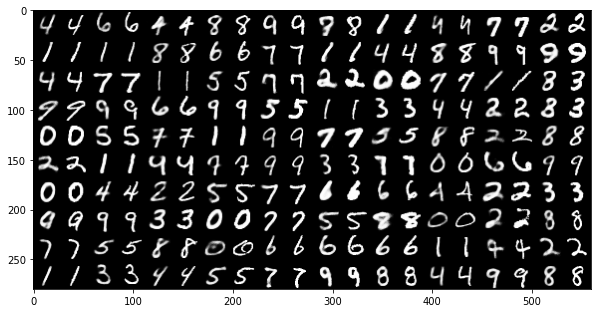

In [0]:
test_reconstruction(model, mnist)

In [0]:
model_2d = trainer(Autoencoder, n_z=2)

[Epoch 0] recon_loss: 207.538  (14.958 sec/epoch)
[Epoch 5] recon_loss: 169.480  (14.833 sec/epoch)
[Epoch 10] recon_loss: 158.588  (14.930 sec/epoch)
[Epoch 15] recon_loss: 140.643  (14.936 sec/epoch)
[Epoch 20] recon_loss: 150.651  (14.777 sec/epoch)
[Epoch 25] recon_loss: 144.901  (14.771 sec/epoch)
[Epoch 30] recon_loss: 143.878  (14.752 sec/epoch)
[Epoch 35] recon_loss: 139.817  (14.954 sec/epoch)
[Epoch 40] recon_loss: 133.354  (14.932 sec/epoch)
[Epoch 45] recon_loss: 137.525  (14.738 sec/epoch)
[Epoch 50] recon_loss: 150.510  (14.743 sec/epoch)
[Epoch 55] recon_loss: 141.051  (14.736 sec/epoch)
[Epoch 60] recon_loss: 135.980  (15.022 sec/epoch)
[Epoch 65] recon_loss: 127.062  (14.797 sec/epoch)
[Epoch 70] recon_loss: 140.727  (14.758 sec/epoch)
[Epoch 75] recon_loss: 137.707  (14.885 sec/epoch)
[Epoch 80] recon_loss: 132.639  (15.087 sec/epoch)
[Epoch 85] recon_loss: 129.892  (15.015 sec/epoch)
[Epoch 90] recon_loss: 147.156  (18.970 sec/epoch)
[Epoch 95] recon_loss: 119.560  (

In [0]:

def test_transformation(model_2d, mnist, batch_size=3000):
    # Test the trained model: transformation
    assert model_2d.n_z == 2
    batch = mnist.test.next_batch(batch_size)
    z = model_2d.transformer(batch[0])
    plt.figure(figsize=(10, 8)) 
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1), s=20)
    plt.colorbar()
    plt.grid()

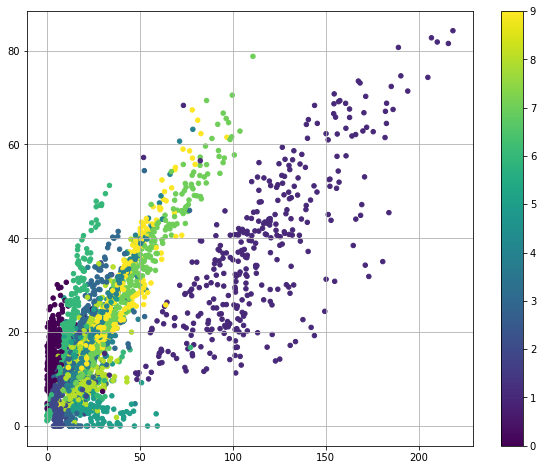

In [0]:
test_transformation(model_2d, mnist)